In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN, MeanShift, Birch
from scipy.stats import skew
from utils import computeBoundaries, plot_and_segment_cube_signals

def clustering_and_plotting(base_path, cube_numbers, excel_path='./experiment_parameters.xlsx', N=1, plot_segmentation=False):
    # Load parameters from Excel into a dictionary
    xl = pd.ExcelFile(excel_path)
    params_dict = {sheet_name: xl.parse(sheet_name)[['Speed (mm/s)', 'Power (W)', 'Power perc (%)']].to_dict('records') for sheet_name in xl.sheet_names}
    
    # Initialize the dictionary to hold the segmented data tensors
    segmented_data_dict = {}
    
    for cube_number in cube_numbers:
        print(f'Working on cube {cube_number}')
        plot_and_segment_cube_signals(base_path, params_dict, cube_number, segmented_data_dict, threshold=0.1, plot_signals=plot_segmentation)
        print('---' * 10)
    
    def extract_features(data):
        features = {}
        
        start_index = int(data.shape[0] * 0.0)
        end_index = int(data.shape[0] * 1.0)
        
        data_emission = np.mean(data[start_index:end_index, 0, :], axis=0)
        features['mean_emission'] = np.mean(data_emission, axis=0)
        features['std_emission'] = np.std(data_emission, axis=0)
        features['median_emission'] = np.median(data_emission, axis=0)
        features['95th_percentile_emission'] = np.percentile(data_emission, 95, axis=0)
        features['5th_percentile_emission'] = np.percentile(data_emission, 5, axis=0)
        features['skewness_emission'] = skew(data_emission, axis=0)
        
        data_reflection = np.mean(data[start_index:end_index, 1, :], axis=0)
        features['mean_reflection'] = np.mean(data_reflection, axis=0)
        features['std_reflection'] = np.std(data_reflection, axis=0)
        features['median_reflection'] = np.median(data_reflection, axis=0)
        features['95th_percentile_reflection'] = np.percentile(data_reflection, 95, axis=0)
        features['5th_percentile_reflection'] = np.percentile(data_reflection, 5, axis=0)
        features['skewness_reflection'] = skew(data_reflection, axis=0)
        
        return features
    
    features_list = []
    label_list = []
    powers = []
    speeds = []

    for key, value in segmented_data_dict.items():
        power, speed, _ = key
        extracted_features = extract_features(value)
        feats = [v for k, v in extracted_features.items()]
        
        features_list.append(np.reshape(feats, (1, len(feats))))
        label_list.append((power, speed))
        powers.append(power)
        speeds.append(speed)

    all_data = []
    for single_power in set(powers):
        single_power_data = { (speed, power): val for (power, speed), val in zip(label_list, features_list) if power == single_power }
        if single_power_data:
            all_data.append(single_power_data)

    clustering_algorithms = {
        'KMeans': KMeans(n_clusters=2, random_state=0),
        'AgglomerativeClustering': AgglomerativeClustering(n_clusters=2),
        'SpectralClustering': SpectralClustering(n_clusters=2),
        #'DBSCAN': DBSCAN(eps=3, min_samples=2),
        'MeanShift': MeanShift(),
        'Birch': Birch(n_clusters=2)
    }

    def prepare_data_for_clustering(data, max_speeds, max_powers):
        to_be_clustered = []
        for k, v in data.items():
            speed, power = k
            num_rows = v.shape[0]
            
            speed_column = np.full((num_rows, 1), speed / max_speeds)
            power_column = np.full((num_rows, 1), power / max_powers)
            
            extended_v = np.hstack((v, speed_column, power_column))
            to_be_clustered.append(extended_v)
        
        X = np.vstack(to_be_clustered)
        X = X[X[:, -2].argsort()]
        
        return X

    def main(all_data):
        max_speeds = max([max(k[0] for k in data.keys()) for data in all_data])
        max_powers = max([max(k[1] for k in data.keys()) for data in all_data])
        
        print(f"Max speed is: {max_speeds}, max power is {max_powers}")
        
        results = {}
        
        for algo_name, algorithm in clustering_algorithms.items():
            all_labels = []
            all_X = []
            
            for i in range(len(all_data)):
                data = all_data[i]
                X = prepare_data_for_clustering(data, max_speeds, max_powers)
            
                print(f"Working with data index {i} for algorithm {algo_name}")
                    
                # Fit the clustering algorithm and predict cluster labels
                if algo_name in ['DBSCAN', 'MeanShift']:
                    labels = algorithm.fit_predict(X)
                    if len(np.unique(labels)) > 2:
                        labels = KMeans(n_clusters=2, random_state=0).fit_predict(labels.reshape(-1, 1))
                elif algo_name == 'SpectralClustering':
                    labels = algorithm.fit_predict(X)
                else:
                    algorithm.fit(X)
                    labels = algorithm.labels_
                
                # Adjust labels to ensure consistency (keyhole = 1, conduction = 0)
                if labels[0] != 1: 
                    labels = 1 - labels

                all_labels.extend(labels)
                all_X.extend(X)

            all_labels = np.array(all_labels)
            all_X = np.array(all_X)
            
            # Define colors for the clusters
            colors = np.where(all_labels == 1, 'red', 'green')

            plt.figure(figsize=(12, 8))
            scatter = plt.scatter(all_X[:, -2] * max_speeds, all_X[:, -1] * max_powers, 
                                  c=colors)

            # Custom legend entries
            plt.scatter([], [], c='red', label='Keyhole')
            plt.scatter([], [], c='green', label='Conduction')

            plt.legend(loc='lower right', bbox_to_anchor=(1, 0.2))
            plt.title(f'Clustering results for all powers ({algo_name})')
            plt.xlabel('Speed (mm/s)')
            plt.ylabel('Power (W)')
            plt.grid()
            
            # Set x and y limits
            plt.xlim(80, 2000)
            plt.ylim(80, 130)
        
            plt.show()
            
            results[algo_name] = {
                'labels': all_labels,
                'speeds': all_X[:, -2] * max_speeds,
                'powers': all_X[:, -1] * max_powers
            }
            
        return results

    return main(all_data)


In [2]:
def extract_info_by_material_and_cubes(material, cubes, data_dict):
    """
    Extract information by material and specified cubes.

    Parameters:
    - material (str): The material to filter by.
    - cubes (list of int): The cube numbers to filter by.
    - data_dict (dict): The dictionary containing the data.

    Returns:
    - dict: A dictionary with keys 'Modes', 'Speeds', 'Power', containing lists of modes, speeds, and powers, respectively.
    """
    extracted_info = {'Modes': [], 'Speeds': [], 'Power': []}
    
    if material == '316L':
        material = 'SS'
    if material== 'Ti64':
        material = 'SS'

    # Filter the entries for the specified material and cubes
    for entry in data_dict[material]:
        if entry['Cube'] in cubes:
            extracted_info['Modes'].append(entry['Mode'])
            extracted_info['Speeds'].append(entry['Speed'])
            extracted_info['Power'].append(entry['Power'])

    return extracted_info

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

def evaluate_clustering(gt_dict, result_dict):
    # Map modes to binary labels
    mode_mapping = {'T': 1, 'TK': 1, 'K': 1, 'C': 0}
    gt_labels = [mode_mapping[mode] for mode in gt_dict['Modes']]
    gt_speeds = gt_dict['Speeds']
    gt_powers = gt_dict['Power']

    metrics = {
        'Algorithm': [],
        'F1 Score': [],
        'Precision': [],
        'Recall': [],
        'Accuracy': []
    }

    for algo_name, algo_result in result_dict.items():
        algo_labels = algo_result['labels']
        algo_speeds = algo_result['speeds']
        algo_powers = algo_result['powers']

        # Align the ground truth and algorithm results
        aligned_gt_labels = []
        aligned_algo_labels = []

        for speed, power in zip(algo_speeds, algo_powers):
            for i in range(len(gt_speeds)):
                if gt_speeds[i] == speed and gt_powers[i] == power:
                    aligned_gt_labels.append(gt_labels[i])
                    aligned_algo_labels.append(algo_labels[np.where((algo_speeds == speed) & (algo_powers == power))[0][0]])
                    break

        # Compute metrics
        f1 = f1_score(aligned_gt_labels, aligned_algo_labels)
        precision = precision_score(aligned_gt_labels, aligned_algo_labels)
        recall = recall_score(aligned_gt_labels, aligned_algo_labels)
        accuracy = accuracy_score(aligned_gt_labels, aligned_algo_labels)

        metrics['Algorithm'].append(algo_name)
        metrics['F1 Score'].append(f1)
        metrics['Precision'].append(precision)
        metrics['Recall'].append(recall)
        metrics['Accuracy'].append(accuracy)

    # Create a DataFrame to display the metrics
    metrics_df = pd.DataFrame(metrics)
    return metrics_df


In [3]:
def load_dictionary(filename):
    with open(filename, 'rb') as file:
        dictionary = pickle.load(file)
    return dictionary

GT = load_dictionary('./GT')

Working on cube 1
Condition 1: Found 10 segments, Avg. Size: 2199.00, Std. Dev: 9.08
Segment Max Size: 2205, Segment Min Size: 2172
Condition 2: Found 12 segments, Avg. Size: 2282.17, Std. Dev: 927.18
Segment Max Size: 2792, Segment Min Size: 220
Condition 3: Found 10 segments, Avg. Size: 1410.10, Std. Dev: 1.30
Segment Max Size: 1412, Segment Min Size: 1407
Condition 4: Found 10 segments, Avg. Size: 1837.00, Std. Dev: 1.48
Segment Max Size: 1839, Segment Min Size: 1835
Condition 5: Found 10 segments, Avg. Size: 3632.10, Std. Dev: 0.54
Segment Max Size: 3633, Segment Min Size: 3631
Condition 6: Found 10 segments, Avg. Size: 2496.10, Std. Dev: 0.83
Segment Max Size: 2498, Segment Min Size: 2495
Condition 7: Found 10 segments, Avg. Size: 1535.10, Std. Dev: 1.22
Segment Max Size: 1538, Segment Min Size: 1534
Condition 8: Found 10 segments, Avg. Size: 1900.30, Std. Dev: 1.79
Segment Max Size: 1905, Segment Min Size: 1898
Condition 9: Found 10 segments, Avg. Size: 1286.40, Std. Dev: 1.28
Se

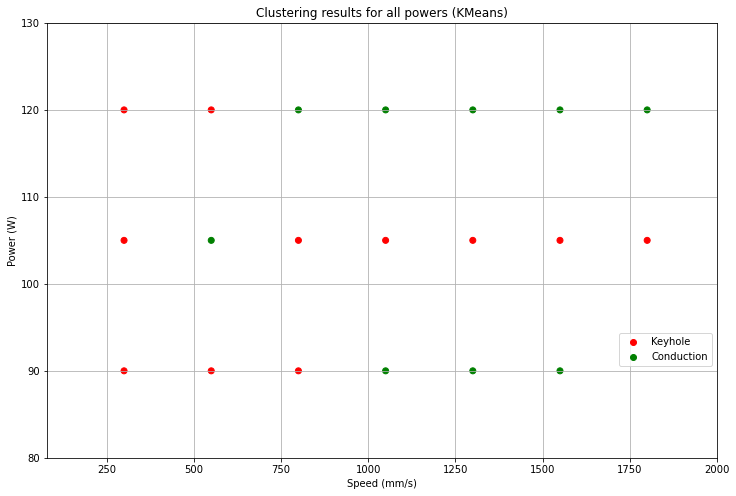

Working with data index 0 for algorithm AgglomerativeClustering
Working with data index 1 for algorithm AgglomerativeClustering
Working with data index 2 for algorithm AgglomerativeClustering


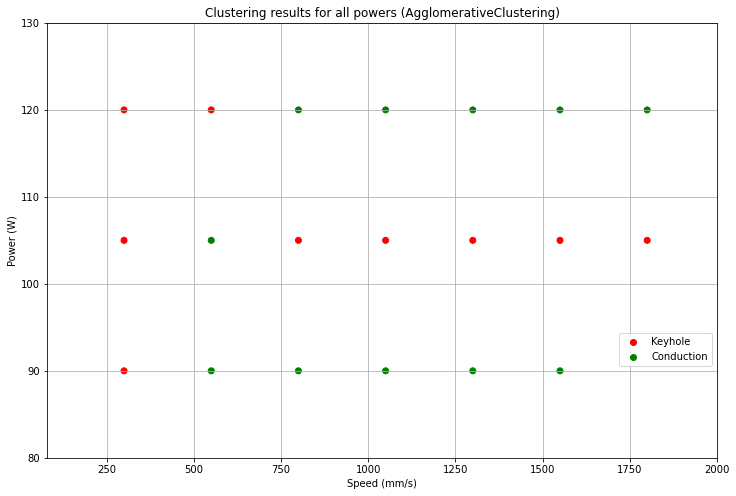

Working with data index 0 for algorithm SpectralClustering
Working with data index 1 for algorithm SpectralClustering
Working with data index 2 for algorithm SpectralClustering


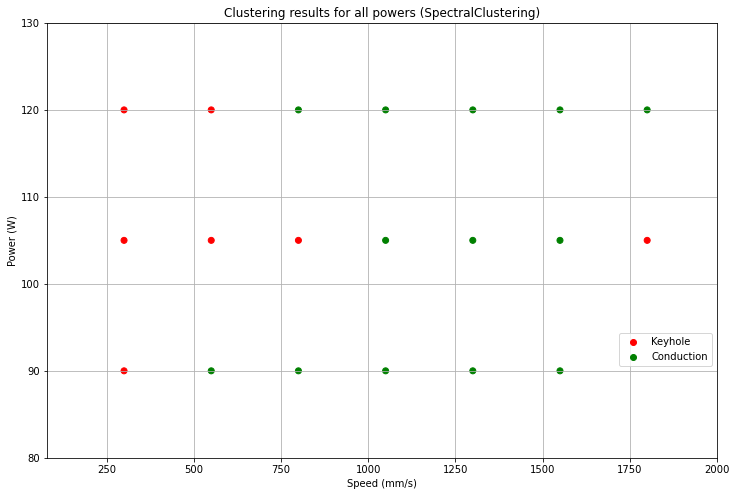

Working with data index 0 for algorithm MeanShift
Working with data index 1 for algorithm MeanShift
Working with data index 2 for algorithm MeanShift


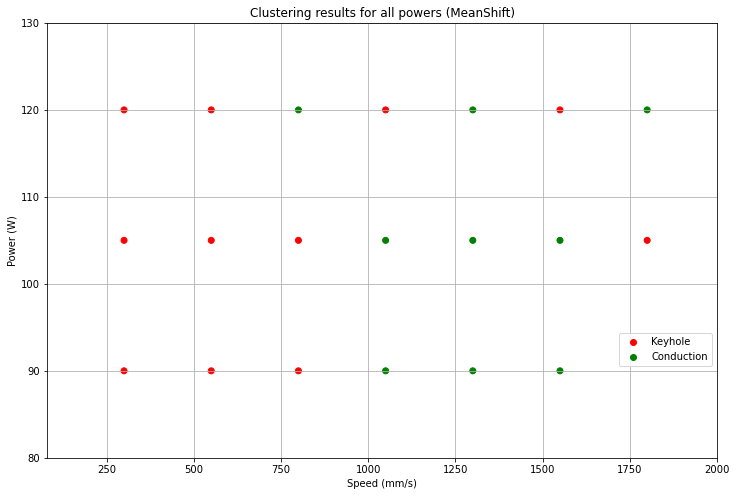

Working with data index 0 for algorithm Birch
Working with data index 1 for algorithm Birch
Working with data index 2 for algorithm Birch


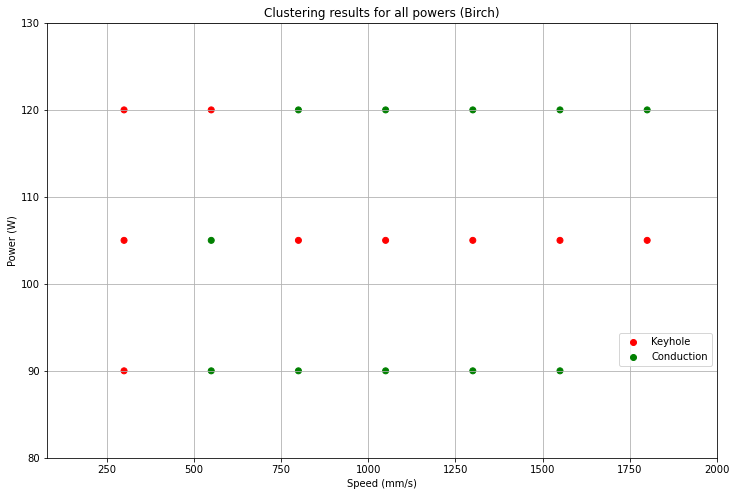

{'KMeans': {'labels': array([1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        dtype=int32),
  'speeds': array([ 300.,  550.,  800., 1050., 1300., 1550., 1800.,  300.,  550.,
          800., 1050., 1300., 1550., 1800.,  300.,  550.,  800., 1050.,
         1300., 1550.]),
  'powers': array([120., 120., 120., 120., 120., 120., 120., 105., 105., 105., 105.,
         105., 105., 105.,  90.,  90.,  90.,  90.,  90.,  90.])},
 'AgglomerativeClustering': {'labels': array([1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]),
  'speeds': array([ 300.,  550.,  800., 1050., 1300., 1550., 1800.,  300.,  550.,
          800., 1050., 1300., 1550., 1800.,  300.,  550.,  800., 1050.,
         1300., 1550.]),
  'powers': array([120., 120., 120., 120., 120., 120., 120., 105., 105., 105., 105.,
         105., 105., 105.,  90.,  90.,  90.,  90.,  90.,  90.])},
 'SpectralClustering': {'labels': array([1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
        dtype=int3

In [4]:
material = '316L'
cubes = [1, 2]
clustering_and_plotting('./Data/Neuchatel_'+material+'/', cubes)

Working on cube 3
Condition 1: Found 10 segments, Avg. Size: 1282.50, Std. Dev: 9.27
Segment Max Size: 1288, Segment Min Size: 1255
Condition 2: Found 10 segments, Avg. Size: 1536.60, Std. Dev: 2.06
Segment Max Size: 1539, Segment Min Size: 1532
Condition 3: Found 10 segments, Avg. Size: 1899.90, Std. Dev: 1.97
Segment Max Size: 1905, Segment Min Size: 1897
Condition 4: Found 10 segments, Avg. Size: 6664.00, Std. Dev: 1.26
Segment Max Size: 6667, Segment Min Size: 6663
Condition 5: Found 10 segments, Avg. Size: 3632.30, Std. Dev: 0.78
Segment Max Size: 3634, Segment Min Size: 3631
Condition 6: Found 10 segments, Avg. Size: 1903.00, Std. Dev: 1.34
Segment Max Size: 1905, Segment Min Size: 1901
Condition 7: Found 10 segments, Avg. Size: 1109.80, Std. Dev: 0.98
Segment Max Size: 1111, Segment Min Size: 1108
Condition 8: Found 10 segments, Avg. Size: 6662.30, Std. Dev: 1.62
Segment Max Size: 6666, Segment Min Size: 6659
Condition 9: Found 10 segments, Avg. Size: 2488.60, Std. Dev: 10.09
Se

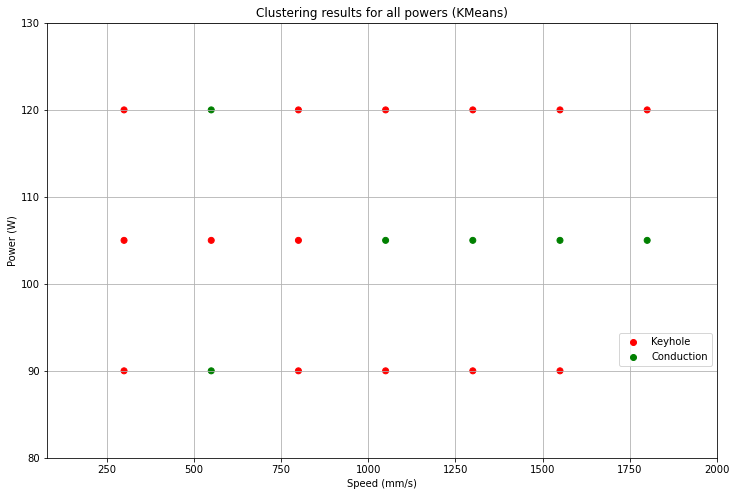

Working with data index 0 for algorithm AgglomerativeClustering
Working with data index 1 for algorithm AgglomerativeClustering
Working with data index 2 for algorithm AgglomerativeClustering


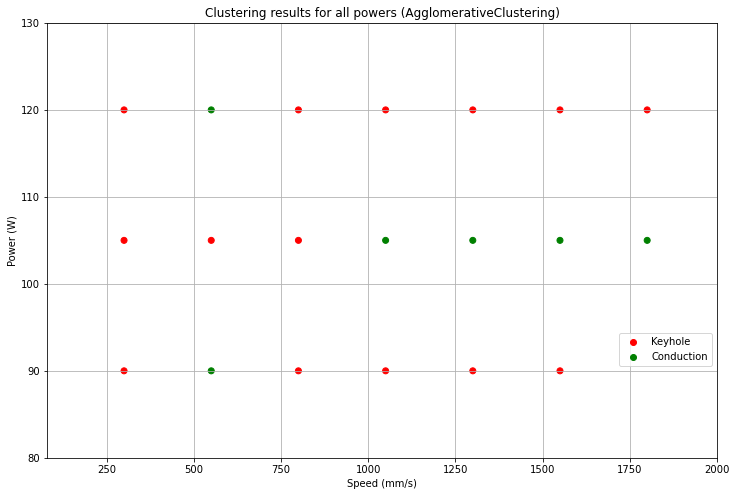

Working with data index 0 for algorithm SpectralClustering
Working with data index 1 for algorithm SpectralClustering
Working with data index 2 for algorithm SpectralClustering


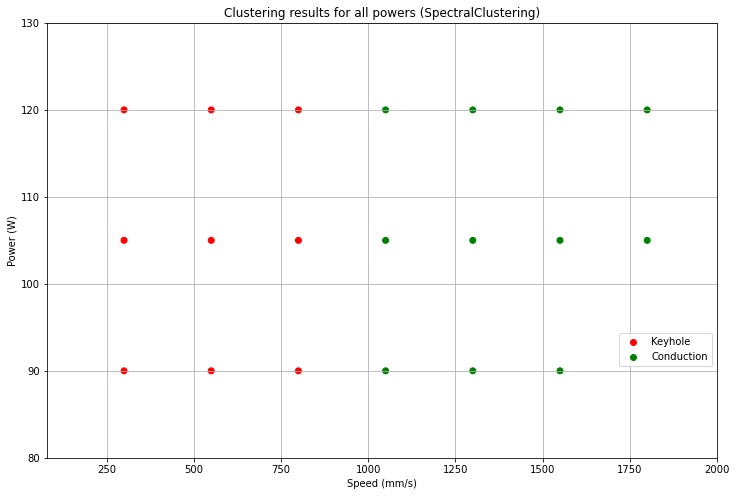

Working with data index 0 for algorithm MeanShift
Working with data index 1 for algorithm MeanShift
Working with data index 2 for algorithm MeanShift


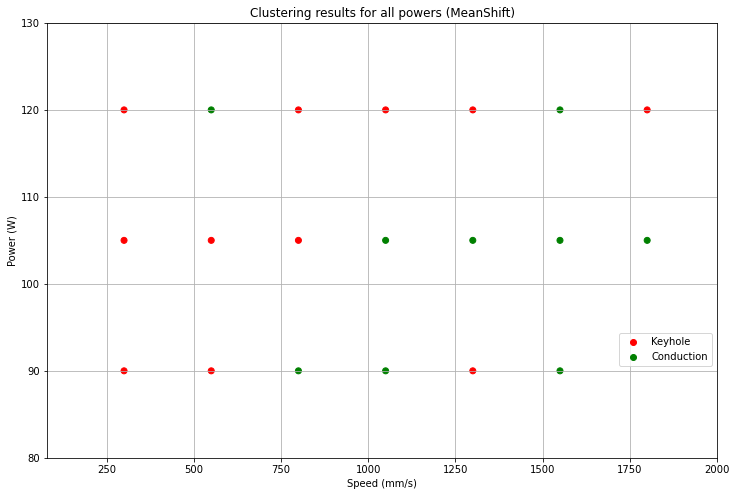

Working with data index 0 for algorithm Birch
Working with data index 1 for algorithm Birch
Working with data index 2 for algorithm Birch


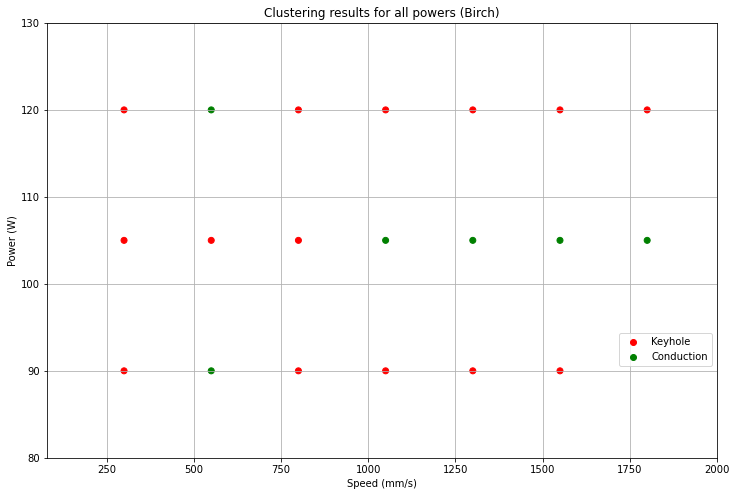

,Algorithm,F1 Score,Precision,Recall,Accuracy
0,KMeans,0.545455,0.428571,0.750,0.50
1,AgglomerativeClustering,0.545455,0.428571,0.750,0.50
2,SpectralClustering,0.941176,0.888889,1.000,0.95
3,MeanShift,0.736842,0.636364,0.875,0.75
4,Birch,0.545455,0.428571,0.750,0.50


In [5]:
material = '316L'
cubes = [3, 4]
res = clustering_and_plotting('./Data/Neuchatel_'+material+'/', cubes)

local_GT = extract_info_by_material_and_cubes(material, cubes, GT)
metrics = evaluate_clustering(local_GT, res)
metrics

In [6]:
res

{'KMeans': {'labels': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1],
        dtype=int32),
  'speeds': array([ 300.,  550.,  800., 1050., 1300., 1550., 1800.,  300.,  550.,
          800., 1050., 1300., 1550., 1800.,  300.,  550.,  800., 1050.,
         1300., 1550.]),
  'powers': array([120., 120., 120., 120., 120., 120., 120., 105., 105., 105., 105.,
         105., 105., 105.,  90.,  90.,  90.,  90.,  90.,  90.])},
 'AgglomerativeClustering': {'labels': array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1]),
  'speeds': array([ 300.,  550.,  800., 1050., 1300., 1550., 1800.,  300.,  550.,
          800., 1050., 1300., 1550., 1800.,  300.,  550.,  800., 1050.,
         1300., 1550.]),
  'powers': array([120., 120., 120., 120., 120., 120., 120., 105., 105., 105., 105.,
         105., 105., 105.,  90.,  90.,  90.,  90.,  90.,  90.])},
 'SpectralClustering': {'labels': array([1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
        dtype=int3

Working on cube 5
Condition 1: Found 10 segments, Avg. Size: 1518.40, Std. Dev: 14.43
Segment Max Size: 1532, Segment Min Size: 1478
Condition 2: Found 10 segments, Avg. Size: 1284.70, Std. Dev: 1.79
Segment Max Size: 1288, Segment Min Size: 1282
Condition 3: Found 10 segments, Avg. Size: 1109.60, Std. Dev: 0.92
Segment Max Size: 1111, Segment Min Size: 1108
Condition 4: Found 10 segments, Avg. Size: 6662.40, Std. Dev: 0.80
Segment Max Size: 6663, Segment Min Size: 6661
Condition 5: Found 11 segments, Avg. Size: 1259.45, Std. Dev: 92.18
Segment Max Size: 1291, Segment Min Size: 968
Condition 6: Found 11 segments, Avg. Size: 1289.36, Std. Dev: 1.49
Segment Max Size: 1292, Segment Min Size: 1286
Condition 7: Found 10 segments, Avg. Size: 1900.40, Std. Dev: 0.66
Segment Max Size: 1902, Segment Min Size: 1900
Condition 8: Found 10 segments, Avg. Size: 2494.80, Std. Dev: 1.40
Segment Max Size: 2496, Segment Min Size: 2491
Condition 9: Found 10 segments, Avg. Size: 1534.80, Std. Dev: 1.54
Se

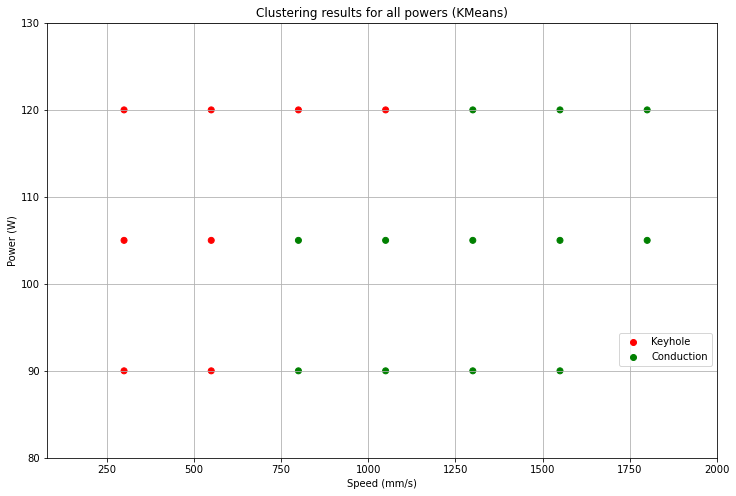

Working with data index 0 for algorithm AgglomerativeClustering
Working with data index 1 for algorithm AgglomerativeClustering
Working with data index 2 for algorithm AgglomerativeClustering


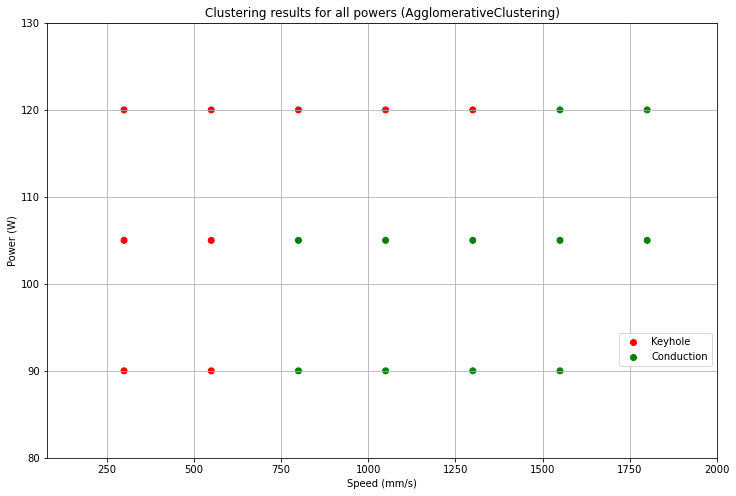

Working with data index 0 for algorithm SpectralClustering
Working with data index 1 for algorithm SpectralClustering
Working with data index 2 for algorithm SpectralClustering


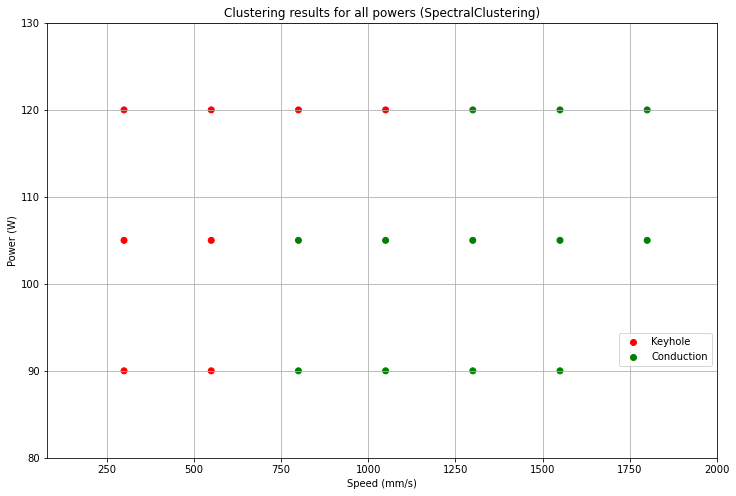

Working with data index 0 for algorithm MeanShift
Working with data index 1 for algorithm MeanShift
Working with data index 2 for algorithm MeanShift


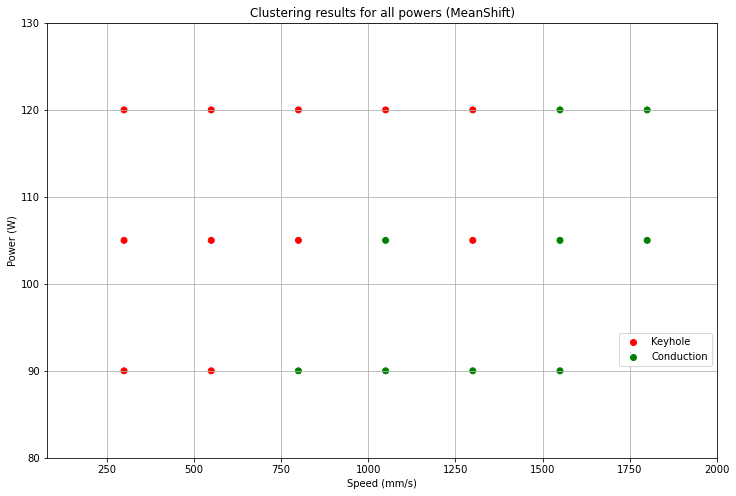

Working with data index 0 for algorithm Birch
Working with data index 1 for algorithm Birch
Working with data index 2 for algorithm Birch


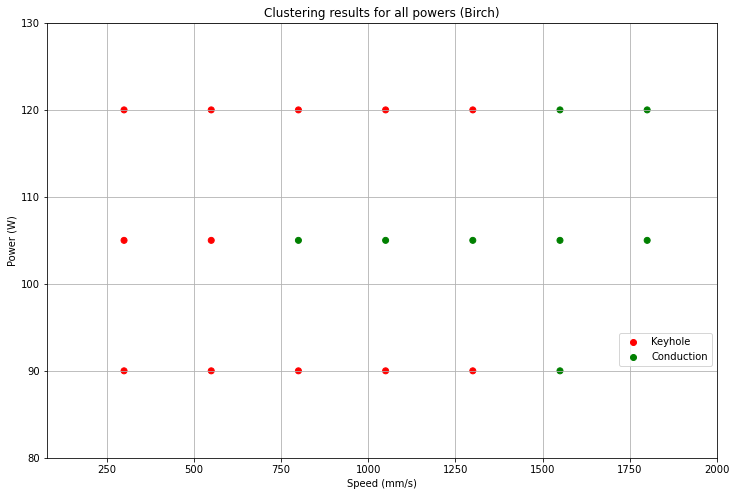

{'KMeans': {'labels': array([1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        dtype=int32),
  'speeds': array([ 300.,  550.,  800., 1050., 1300., 1550., 1800.,  300.,  550.,
          800., 1050., 1300., 1550., 1800.,  300.,  550.,  800., 1050.,
         1300., 1550.]),
  'powers': array([120., 120., 120., 120., 120., 120., 120., 105., 105., 105., 105.,
         105., 105., 105.,  90.,  90.,  90.,  90.,  90.,  90.])},
 'AgglomerativeClustering': {'labels': array([1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]),
  'speeds': array([ 300.,  550.,  800., 1050., 1300., 1550., 1800.,  300.,  550.,
          800., 1050., 1300., 1550., 1800.,  300.,  550.,  800., 1050.,
         1300., 1550.]),
  'powers': array([120., 120., 120., 120., 120., 120., 120., 105., 105., 105., 105.,
         105., 105., 105.,  90.,  90.,  90.,  90.,  90.,  90.])},
 'SpectralClustering': {'labels': array([1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        dtype=int3

In [7]:
clustering_and_plotting('./Data/Neuchatel_316L/', [5, 6])


Working on cube 7
Condition 1: Found 11 segments, Avg. Size: 5797.45, Std. Dev: 1795.03
Segment Max Size: 6660, Segment Min Size: 215
Condition 2: Found 10 segments, Avg. Size: 1214.30, Std. Dev: 1.19
Segment Max Size: 1217, Segment Min Size: 1213
Condition 3: Found 10 segments, Avg. Size: 1344.40, Std. Dev: 1.62
Segment Max Size: 1346, Segment Min Size: 1340
Condition 4: Found 10 segments, Avg. Size: 5272.80, Std. Dev: 0.60
Segment Max Size: 5274, Segment Min Size: 5272
Condition 5: Found 10 segments, Avg. Size: 2142.40, Std. Dev: 1.43
Segment Max Size: 2146, Segment Min Size: 2141
Condition 6: Found 10 segments, Avg. Size: 2873.50, Std. Dev: 0.50
Segment Max Size: 2874, Segment Min Size: 2873
Condition 7: Found 10 segments, Avg. Size: 1708.40, Std. Dev: 1.02
Segment Max Size: 1711, Segment Min Size: 1707
Condition 8: Found 10 segments, Avg. Size: 3717.20, Std. Dev: 2.60
Segment Max Size: 3720, Segment Min Size: 3711
Condition 9: Found 10 segments, Avg. Size: 1156.10, Std. Dev: 3.42
S

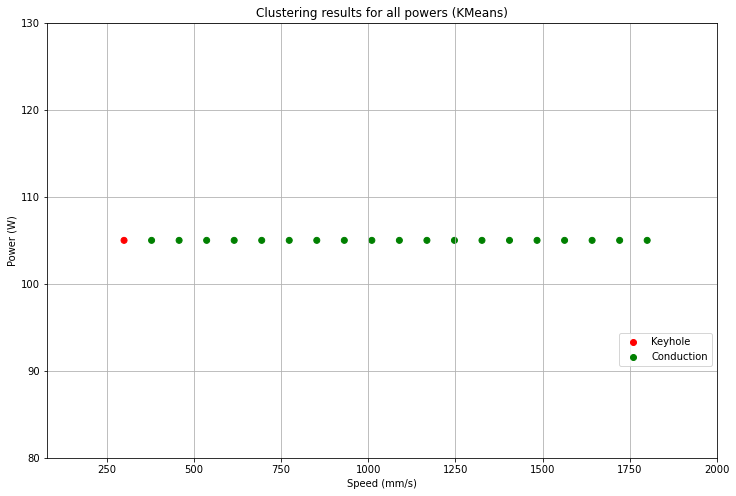

Working with data index 0 for algorithm AgglomerativeClustering


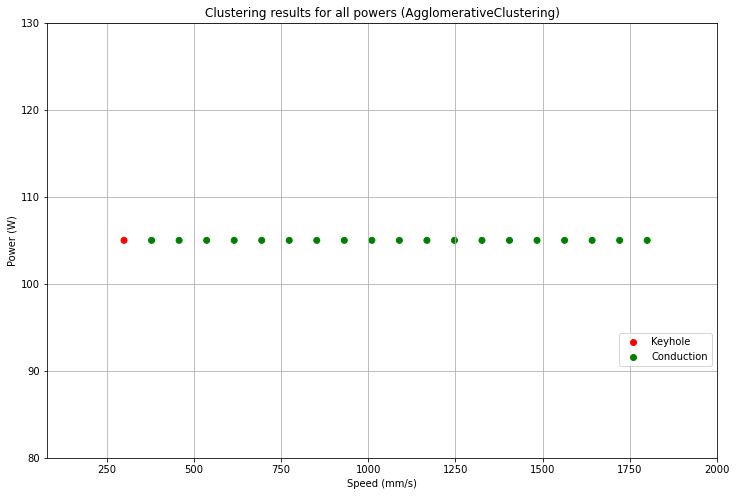

Working with data index 0 for algorithm SpectralClustering


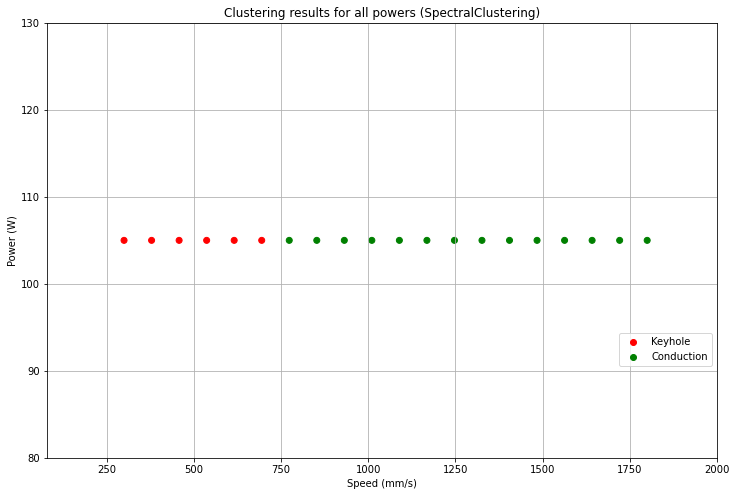

Working with data index 0 for algorithm MeanShift


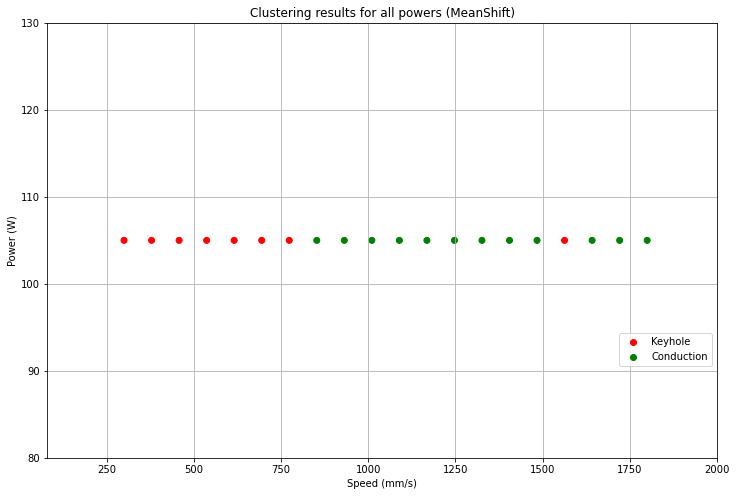

Working with data index 0 for algorithm Birch


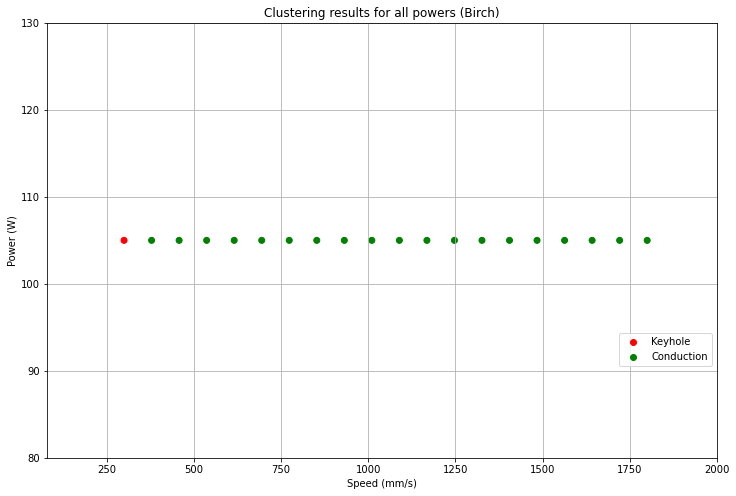

,Algorithm,F1 Score,Precision,Recall,Accuracy
0,KMeans,0.285714,1.000000,0.166667,0.722222
1,AgglomerativeClustering,0.285714,1.000000,0.166667,0.722222
2,SpectralClustering,0.909091,1.000000,0.833333,0.944444
3,MeanShift,0.923077,0.857143,1.000000,0.944444
4,Birch,0.285714,1.000000,0.166667,0.722222


In [8]:
material = '316L'
cubes = [7, 8]
res = clustering_and_plotting('./Data/Neuchatel_'+material+'/', cubes)

local_GT = extract_info_by_material_and_cubes(material, cubes, GT)
metrics = evaluate_clustering(local_GT, res)
metrics

Working on cube 1
Condition 1: Found 7 segments, Avg. Size: 2196.57, Std. Dev: 12.53
Segment Max Size: 2204, Segment Min Size: 2166
Condition 2: Found 8 segments, Avg. Size: 2799.38, Std. Dev: 1.58
Segment Max Size: 2802, Segment Min Size: 2797
Condition 3: Found 10 segments, Avg. Size: 1363.40, Std. Dev: 134.26
Segment Max Size: 1414, Segment Min Size: 962
Condition 4: Found 6 segments, Avg. Size: 1838.00, Std. Dev: 1.83
Segment Max Size: 1840, Segment Min Size: 1835
Condition 5: Found 10 segments, Avg. Size: 3634.70, Std. Dev: 1.10
Segment Max Size: 3636, Segment Min Size: 3633
Condition 6: Found 10 segments, Avg. Size: 2499.20, Std. Dev: 0.98
Segment Max Size: 2501, Segment Min Size: 2498
Condition 7: Found 10 segments, Avg. Size: 1537.30, Std. Dev: 0.78
Segment Max Size: 1539, Segment Min Size: 1536
Condition 8: Found 10 segments, Avg. Size: 1903.10, Std. Dev: 0.83
Segment Max Size: 1904, Segment Min Size: 1902
Condition 9: Found 10 segments, Avg. Size: 1289.30, Std. Dev: 1.55
Segm

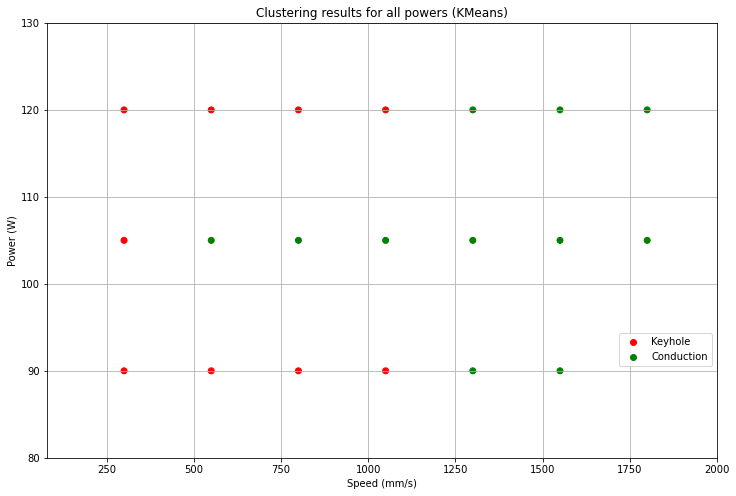

Working with data index 0 for algorithm AgglomerativeClustering
Working with data index 1 for algorithm AgglomerativeClustering
Working with data index 2 for algorithm AgglomerativeClustering


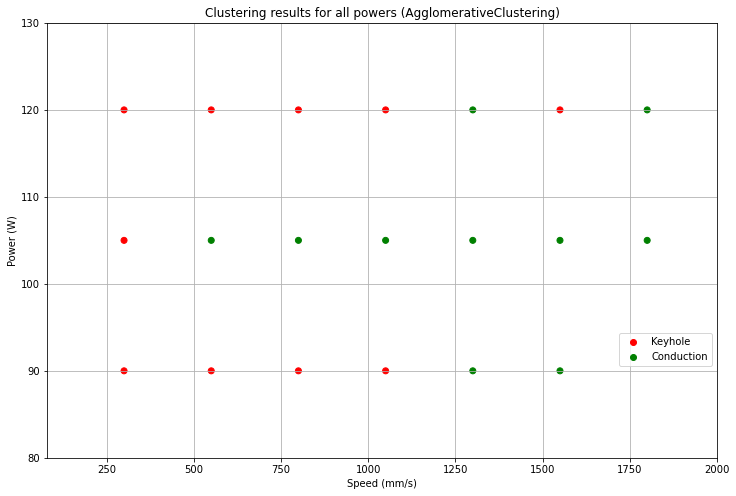

Working with data index 0 for algorithm SpectralClustering
Working with data index 1 for algorithm SpectralClustering
Working with data index 2 for algorithm SpectralClustering


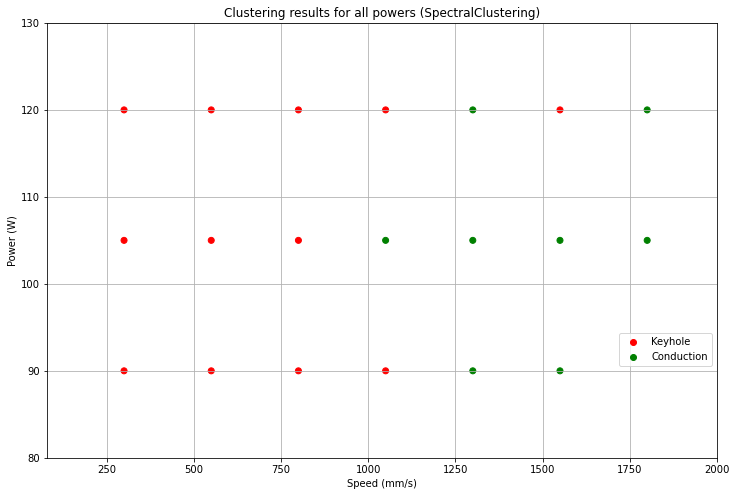

Working with data index 0 for algorithm MeanShift
Working with data index 1 for algorithm MeanShift
Working with data index 2 for algorithm MeanShift


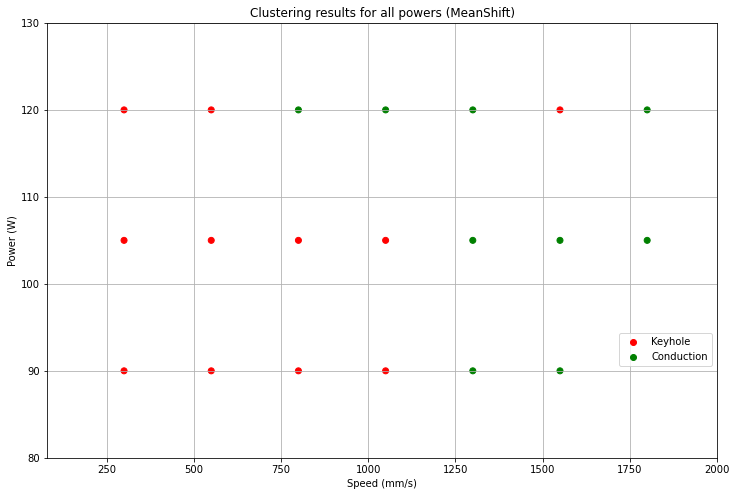

Working with data index 0 for algorithm Birch
Working with data index 1 for algorithm Birch
Working with data index 2 for algorithm Birch


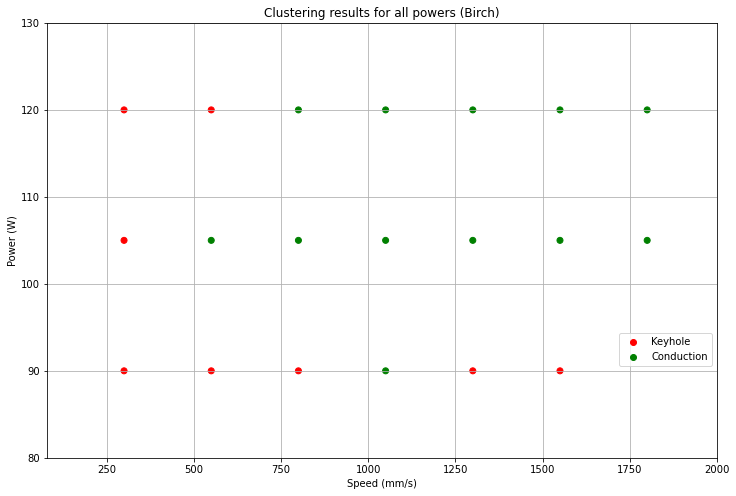

{'KMeans': {'labels': array([1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0],
        dtype=int32),
  'speeds': array([ 300.,  550.,  800., 1050., 1300., 1550., 1800.,  300.,  550.,
          800., 1050., 1300., 1550., 1800.,  300.,  550.,  800., 1050.,
         1300., 1550.]),
  'powers': array([120., 120., 120., 120., 120., 120., 120., 105., 105., 105., 105.,
         105., 105., 105.,  90.,  90.,  90.,  90.,  90.,  90.])},
 'AgglomerativeClustering': {'labels': array([1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0]),
  'speeds': array([ 300.,  550.,  800., 1050., 1300., 1550., 1800.,  300.,  550.,
          800., 1050., 1300., 1550., 1800.,  300.,  550.,  800., 1050.,
         1300., 1550.]),
  'powers': array([120., 120., 120., 120., 120., 120., 120., 105., 105., 105., 105.,
         105., 105., 105.,  90.,  90.,  90.,  90.,  90.,  90.])},
 'SpectralClustering': {'labels': array([1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0],
        dtype=int3

In [9]:
clustering_and_plotting('./Data/Neuchatel_Ti64/', [1, 2])


Working on cube 3
Condition 1: Found 10 segments, Avg. Size: 1284.40, Std. Dev: 8.82
Segment Max Size: 1288, Segment Min Size: 1258
Condition 2: Found 10 segments, Avg. Size: 1536.70, Std. Dev: 1.10
Segment Max Size: 1538, Segment Min Size: 1535
Condition 3: Found 10 segments, Avg. Size: 1901.20, Std. Dev: 2.23
Segment Max Size: 1903, Segment Min Size: 1895
Condition 4: Found 10 segments, Avg. Size: 6663.80, Std. Dev: 1.08
Segment Max Size: 6666, Segment Min Size: 6662
Condition 5: Found 10 segments, Avg. Size: 3634.20, Std. Dev: 0.75
Segment Max Size: 3635, Segment Min Size: 3633
Condition 6: Found 10 segments, Avg. Size: 1904.40, Std. Dev: 0.66
Segment Max Size: 1905, Segment Min Size: 1903
Condition 7: Found 10 segments, Avg. Size: 1110.80, Std. Dev: 0.87
Segment Max Size: 1112, Segment Min Size: 1109
Condition 8: Found 10 segments, Avg. Size: 6664.20, Std. Dev: 0.87
Segment Max Size: 6666, Segment Min Size: 6663
Condition 9: Found 10 segments, Avg. Size: 2497.80, Std. Dev: 1.33
Seg

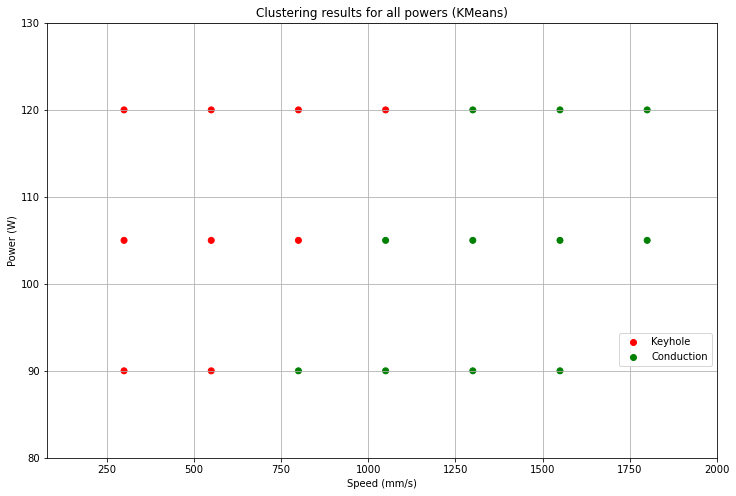

Working with data index 0 for algorithm AgglomerativeClustering
Working with data index 1 for algorithm AgglomerativeClustering
Working with data index 2 for algorithm AgglomerativeClustering


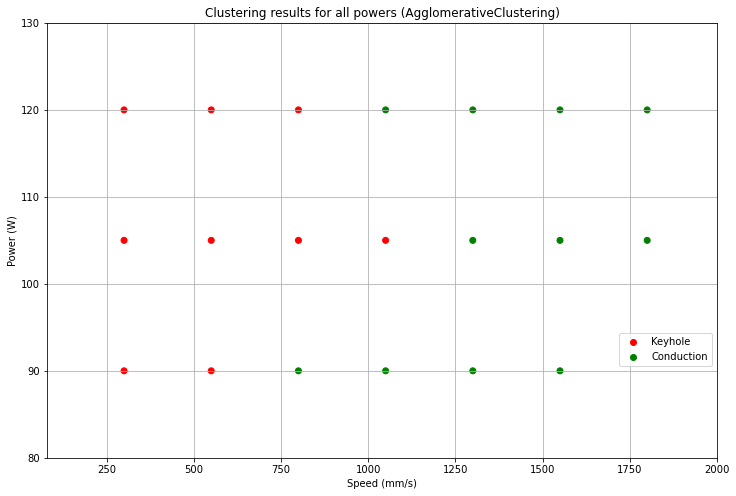

Working with data index 0 for algorithm SpectralClustering
Working with data index 1 for algorithm SpectralClustering
Working with data index 2 for algorithm SpectralClustering


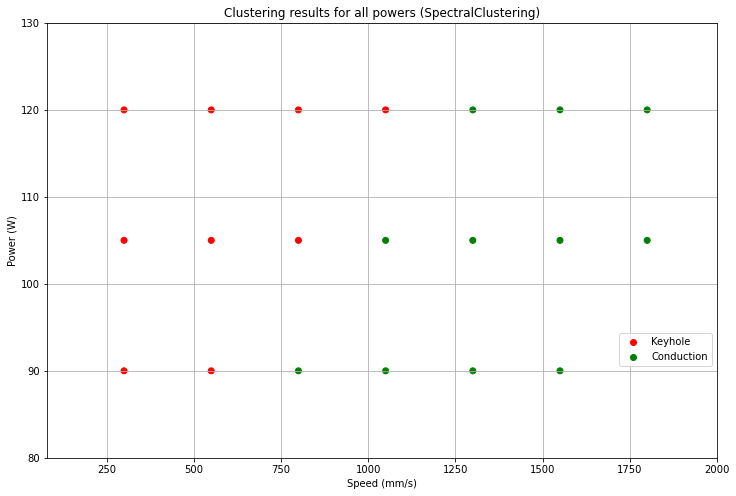

Working with data index 0 for algorithm MeanShift
Working with data index 1 for algorithm MeanShift
Working with data index 2 for algorithm MeanShift


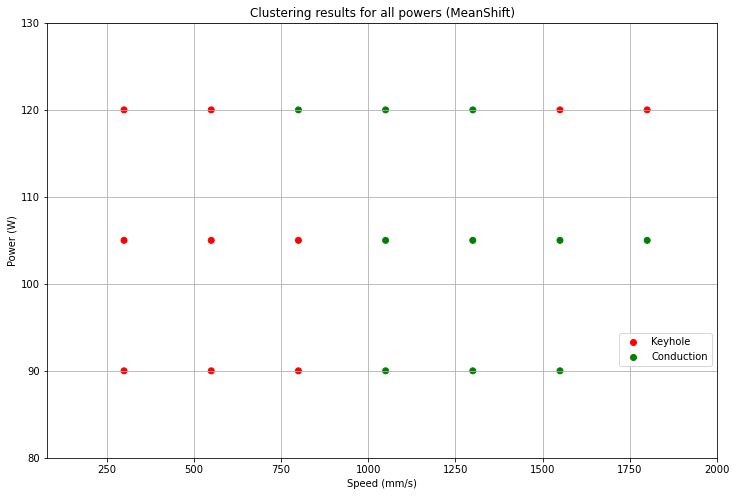

Working with data index 0 for algorithm Birch
Working with data index 1 for algorithm Birch
Working with data index 2 for algorithm Birch


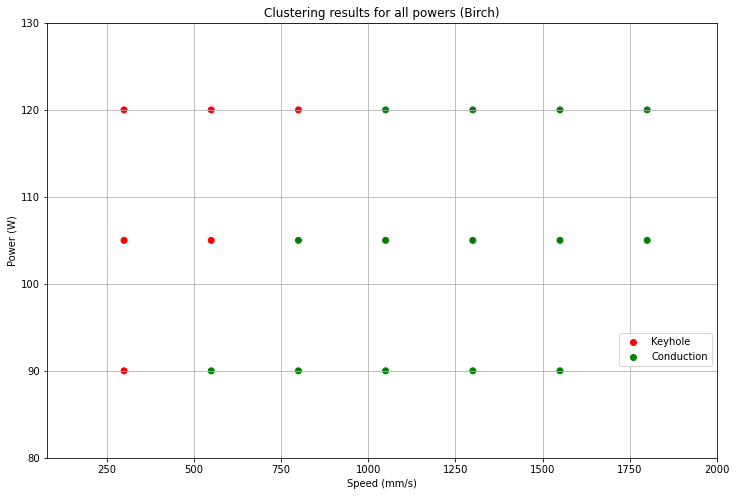

,Algorithm,F1 Score,Precision,Recall,Accuracy
0,KMeans,0.941176,0.888889,1.000,0.95
1,AgglomerativeClustering,0.941176,0.888889,1.000,0.95
2,SpectralClustering,0.941176,0.888889,1.000,0.95
3,MeanShift,0.777778,0.700000,0.875,0.80
4,Birch,0.857143,1.000000,0.750,0.90


In [10]:
material = 'Ti64'
cubes = [3, 4]
res = clustering_and_plotting('./Data/Neuchatel_'+material+'/', cubes)

local_GT = extract_info_by_material_and_cubes(material, cubes, GT)
metrics = evaluate_clustering(local_GT, res)
metrics

Working on cube 5
Condition 1: Found 10 segments, Avg. Size: 1531.90, Std. Dev: 10.65
Segment Max Size: 1536, Segment Min Size: 1500
Condition 2: Found 10 segments, Avg. Size: 1289.10, Std. Dev: 0.83
Segment Max Size: 1291, Segment Min Size: 1288
Condition 3: Found 10 segments, Avg. Size: 1111.10, Std. Dev: 0.94
Segment Max Size: 1112, Segment Min Size: 1109
Condition 4: Found 10 segments, Avg. Size: 6665.00, Std. Dev: 1.26
Segment Max Size: 6667, Segment Min Size: 6663
Condition 5: Found 11 segments, Avg. Size: 1259.73, Std. Dev: 93.21
Segment Max Size: 1291, Segment Min Size: 965
Condition 6: Found 11 segments, Avg. Size: 1290.18, Std. Dev: 1.40
Segment Max Size: 1293, Segment Min Size: 1288
Condition 7: Found 10 segments, Avg. Size: 1903.10, Std. Dev: 1.04
Segment Max Size: 1905, Segment Min Size: 1901
Condition 8: Found 10 segments, Avg. Size: 2497.30, Std. Dev: 1.85
Segment Max Size: 2500, Segment Min Size: 2493
Condition 9: Found 10 segments, Avg. Size: 1537.40, Std. Dev: 1.11
Se

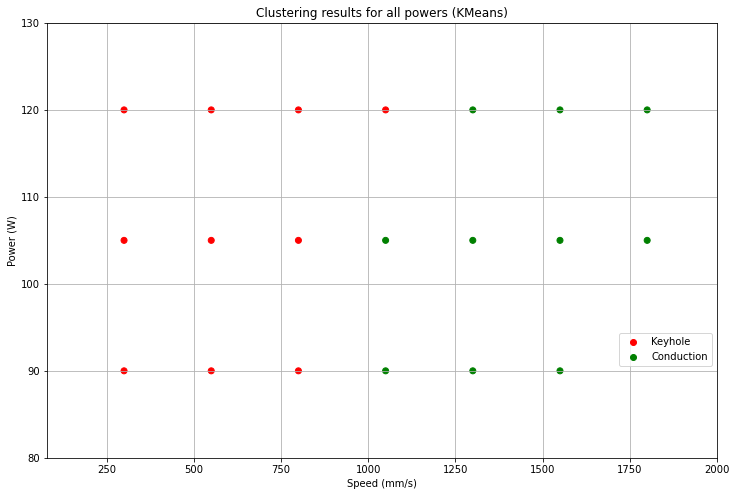

Working with data index 0 for algorithm AgglomerativeClustering
Working with data index 1 for algorithm AgglomerativeClustering
Working with data index 2 for algorithm AgglomerativeClustering


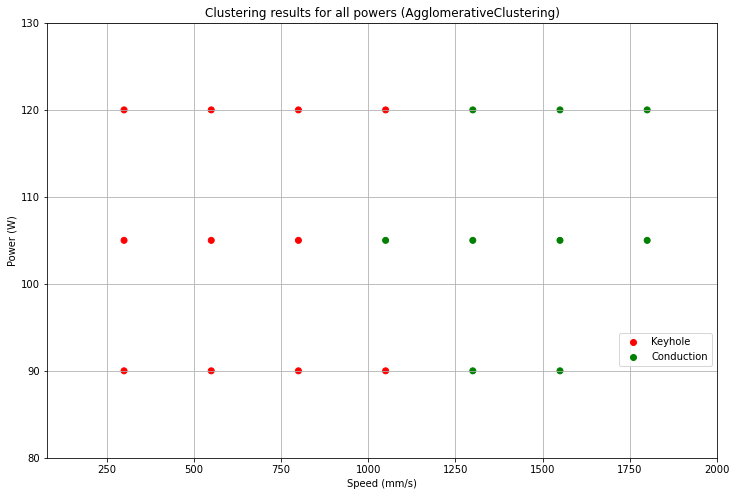

Working with data index 0 for algorithm SpectralClustering
Working with data index 1 for algorithm SpectralClustering
Working with data index 2 for algorithm SpectralClustering


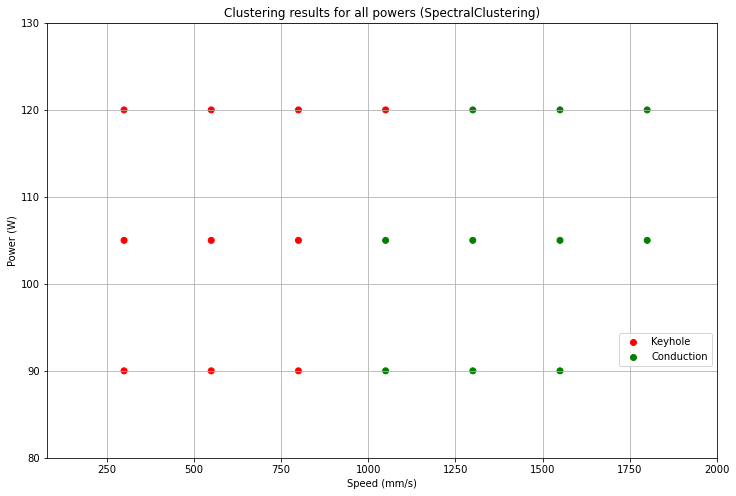

Working with data index 0 for algorithm MeanShift
Working with data index 1 for algorithm MeanShift
Working with data index 2 for algorithm MeanShift


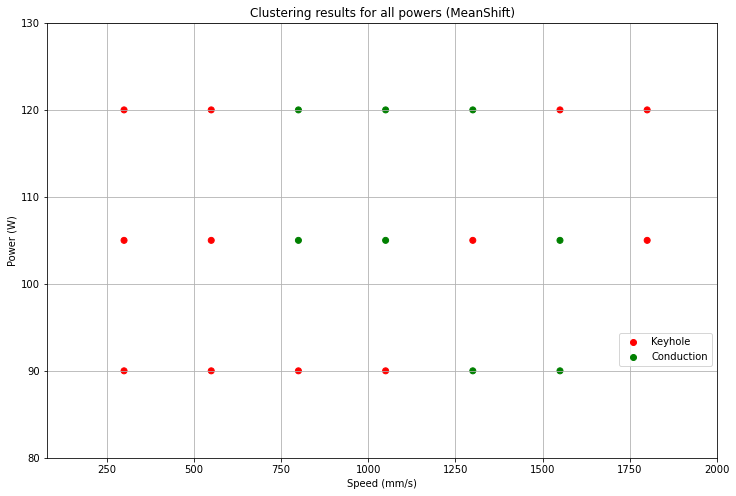

Working with data index 0 for algorithm Birch
Working with data index 1 for algorithm Birch
Working with data index 2 for algorithm Birch


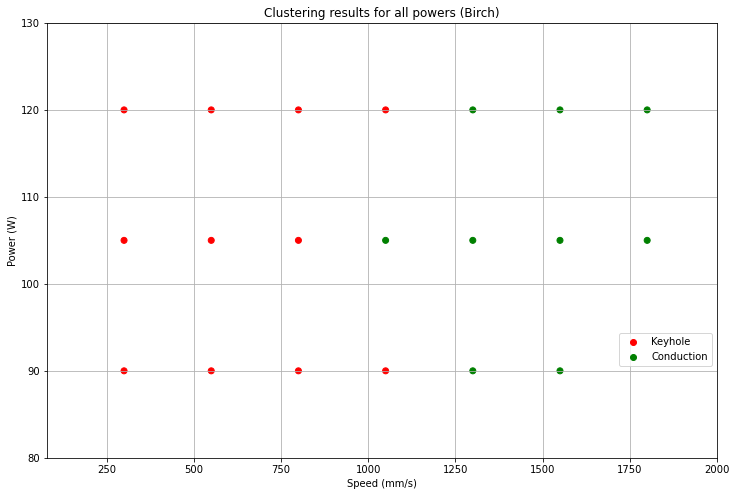

{'KMeans': {'labels': array([1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
        dtype=int32),
  'speeds': array([ 300.,  550.,  800., 1050., 1300., 1550., 1800.,  300.,  550.,
          800., 1050., 1300., 1550., 1800.,  300.,  550.,  800., 1050.,
         1300., 1550.]),
  'powers': array([120., 120., 120., 120., 120., 120., 120., 105., 105., 105., 105.,
         105., 105., 105.,  90.,  90.,  90.,  90.,  90.,  90.])},
 'AgglomerativeClustering': {'labels': array([1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0]),
  'speeds': array([ 300.,  550.,  800., 1050., 1300., 1550., 1800.,  300.,  550.,
          800., 1050., 1300., 1550., 1800.,  300.,  550.,  800., 1050.,
         1300., 1550.]),
  'powers': array([120., 120., 120., 120., 120., 120., 120., 105., 105., 105., 105.,
         105., 105., 105.,  90.,  90.,  90.,  90.,  90.,  90.])},
 'SpectralClustering': {'labels': array([1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
        dtype=int3

In [11]:
clustering_and_plotting('./Data/Neuchatel_Ti64/', [5, 6])


Working on cube 7
Condition 1: Found 10 segments, Avg. Size: 6660.00, Std. Dev: 8.71
Segment Max Size: 6664, Segment Min Size: 6634
Condition 2: Found 10 segments, Avg. Size: 1217.40, Std. Dev: 0.66
Segment Max Size: 1218, Segment Min Size: 1216
Condition 3: Found 10 segments, Avg. Size: 1347.10, Std. Dev: 0.70
Segment Max Size: 1348, Segment Min Size: 1346
Condition 4: Found 10 segments, Avg. Size: 5275.30, Std. Dev: 1.10
Segment Max Size: 5277, Segment Min Size: 5274
Condition 5: Found 10 segments, Avg. Size: 2144.30, Std. Dev: 0.64
Segment Max Size: 2145, Segment Min Size: 2143
Condition 6: Found 10 segments, Avg. Size: 2876.40, Std. Dev: 0.66
Segment Max Size: 2878, Segment Min Size: 2876
Condition 7: Found 10 segments, Avg. Size: 1711.40, Std. Dev: 0.66
Segment Max Size: 1713, Segment Min Size: 1711
Condition 8: Found 10 segments, Avg. Size: 3722.10, Std. Dev: 0.70
Segment Max Size: 3723, Segment Min Size: 3721
Condition 9: Found 10 segments, Avg. Size: 1162.80, Std. Dev: 1.08
Seg

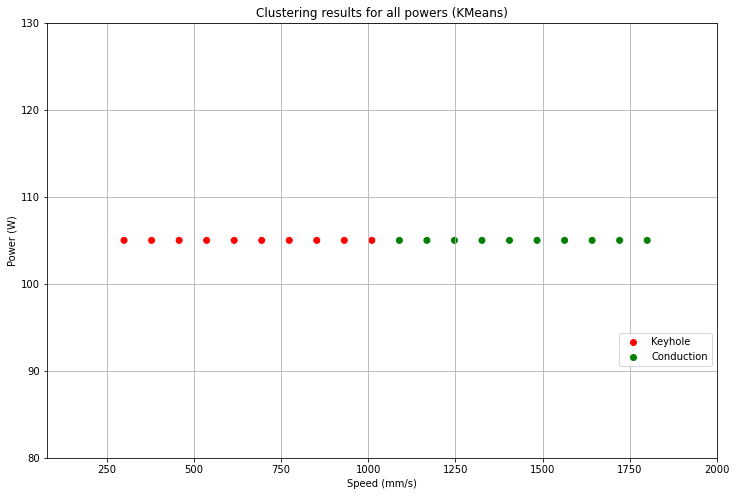

Working with data index 0 for algorithm AgglomerativeClustering


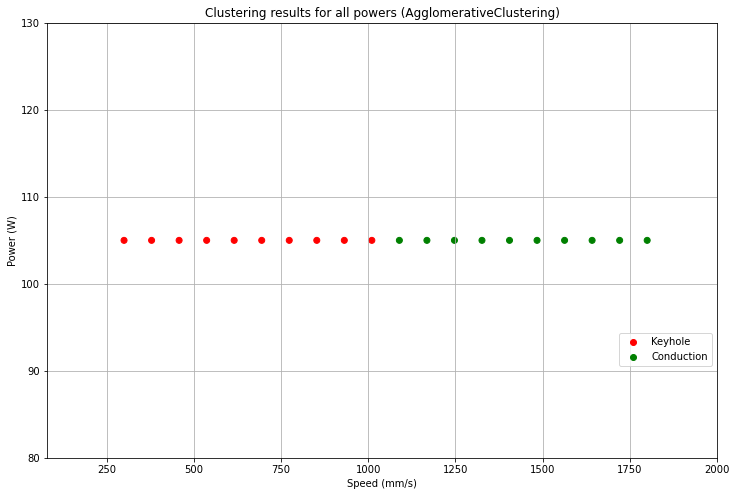

Working with data index 0 for algorithm SpectralClustering


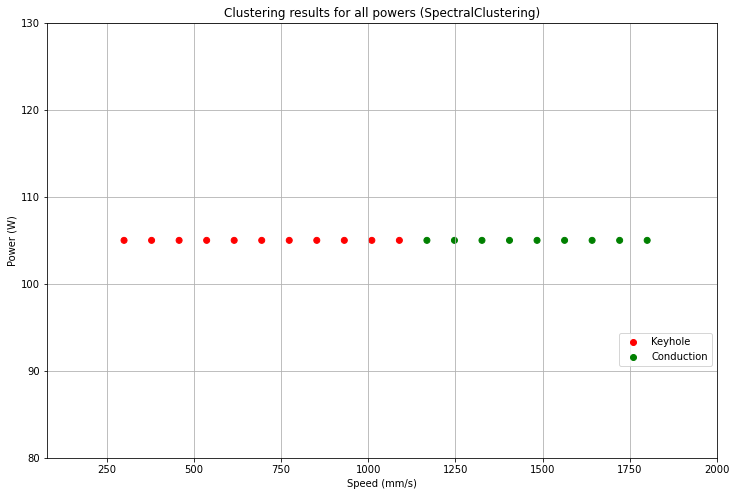

Working with data index 0 for algorithm MeanShift


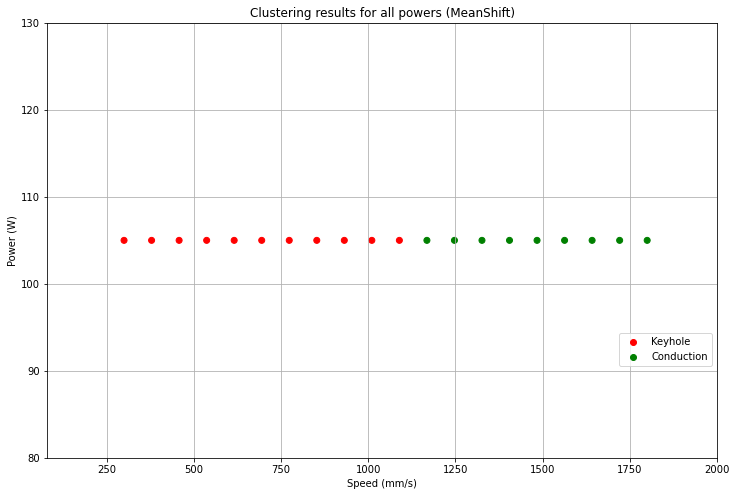

Working with data index 0 for algorithm Birch


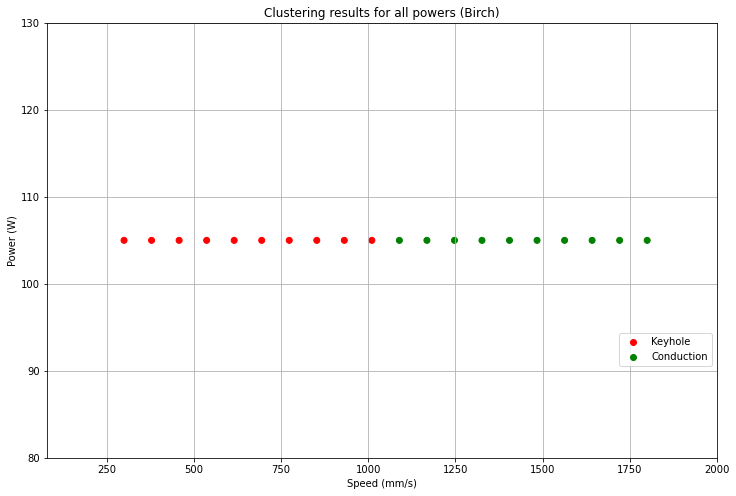

,Algorithm,F1 Score,Precision,Recall,Accuracy
0,KMeans,0.857143,0.750000,1.0,0.888889
1,AgglomerativeClustering,0.857143,0.750000,1.0,0.888889
2,SpectralClustering,0.800000,0.666667,1.0,0.833333
3,MeanShift,0.800000,0.666667,1.0,0.833333
4,Birch,0.857143,0.750000,1.0,0.888889


In [12]:
material = 'Ti64'
cubes = [7, 8]
res = clustering_and_plotting('./Data/Neuchatel_'+material+'/', cubes)

local_GT = extract_info_by_material_and_cubes(material, cubes, GT)
metrics = evaluate_clustering(local_GT, res)
metrics